In [1]:
import pandas as pd
import numpy as np
import os
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageFile
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import pickle
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import umap

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

2024-11-22 14:42:30.682606: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 14:42:30.782597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 14:42:30.827458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 14:42:30.840309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 14:42:30.905294: I tensorflow/core/platform/cpu_feature_guar

In [2]:
path = "/media/guimcc/Elements/data_2"

# Load sales data
train_df = pd.read_csv(Path(path + '/train.csv'), parse_dates=['release_date'])
test_df = pd.read_csv(Path(path + '/test.csv'), parse_dates=['release_date'])

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


class ZeroShotDataset():
    def __init__(self, data_df, img_root, gtrends, cat_dict, col_dict, fab_dict, trend_len):
        self.data_df = data_df
        self.gtrends = gtrends
        self.cat_dict = cat_dict
        self.col_dict = col_dict
        self.fab_dict = fab_dict
        self.trend_len = trend_len
        self.img_root = img_root

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        return self.data_df.iloc[idx, :]

    def preprocess_data(self):
        data = self.data_df

        # Get the Gtrends time series associated with each product
        # Read the images (extracted image features) as well
        gtrends, image_features = [], []
        img_transforms = Compose([Resize((256, 256)), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        for (idx, row) in tqdm(data.iterrows(), total=len(data), ascii=True):
            cat, col, fab, fiq_attr, start_date, img_path = row['category'], row['color'], row['fabric'], row['extra'], \
                row['release_date'], row['image_path']

            # Get the gtrend signal up to the previous year (52 weeks) of the release date
            gtrend_start = start_date - pd.DateOffset(weeks=52) # Set the initial date to 52 weeks before the release date
            cat_gtrend = self.gtrends.loc[gtrend_start:start_date][cat][-52:].values[:self.trend_len] # Get the last 52 weeks of the gtrend signal and "store - it" to each item
            col_gtrend = self.gtrends.loc[gtrend_start:start_date][col][-52:].values[:self.trend_len]
            fab_gtrend = self.gtrends.loc[gtrend_start:start_date][fab][-52:].values[:self.trend_len]

            cat_gtrend = MinMaxScaler().fit_transform(cat_gtrend.reshape(-1,1)).flatten() # Normalize the gtrend signals - all categories on the same scale
            col_gtrend = MinMaxScaler().fit_transform(col_gtrend.reshape(-1,1)).flatten()
            fab_gtrend = MinMaxScaler().fit_transform(fab_gtrend.reshape(-1,1)).flatten()
            multitrends =  np.vstack([cat_gtrend, col_gtrend, fab_gtrend])


            # Read images
            img = Image.open(os.path.join(self.img_root, img_path)).convert('RGB')

            # Append them to the lists
            gtrends.append(multitrends)
            image_features.append(img_transforms(img))

        # Convert to numpy arrays
        gtrends = np.array(gtrends)

        # Remove non-numerical information
        data.drop(['external_code', 'season', 'release_date', 'image_path'], axis=1, inplace=True)

        # Create tensors for each part of the input/output
        item_sales, temporal_features = torch.FloatTensor(data.iloc[:, :12].values), torch.FloatTensor(
            data.iloc[:, 13:17].values)
        categories, colors, fabrics = [self.cat_dict[val] for val in data.iloc[:].category.values], \
                                       [self.col_dict[val] for val in data.iloc[:].color.values], \
                                       [self.fab_dict[val] for val in data.iloc[:].fabric.values]

        
        categories, colors, fabrics = torch.LongTensor(categories), torch.LongTensor(colors), torch.LongTensor(fabrics)
        gtrends = torch.FloatTensor(gtrends)
        images = torch.stack(image_features)

        return TensorDataset(item_sales, categories, colors, fabrics, temporal_features, gtrends, images)

    def get_loader(self, batch_size, train=True):
        print('Starting dataset creation process...')
        data_with_gtrends = self.preprocess_data()
        data_loader = None
        if train:
            data_loader = DataLoader(data_with_gtrends, batch_size=batch_size, shuffle=True, num_workers=4)
        else:
            data_loader = DataLoader(data_with_gtrends, batch_size=1, shuffle=False, num_workers=4)
        print('Done.')

        return data_loader

In [4]:
from pathlib import Path

 # Load category and color encodings
cat_dict = torch.load(Path(path + '/category_labels.pt'))
col_dict = torch.load(Path(path + '/color_labels.pt'))
fab_dict = torch.load(Path(path + '/fabric_labels.pt'))

gtrends = pd.read_csv(Path(path + '/gtrends.csv'), index_col=[0], parse_dates=True)

/tmp/ipykernel_6981/1618174958.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cat_dict = torch.load(Path(path + '/category_labels.pt'))
/tmp/ipykernel_6981/1618174958.p

In [5]:
train_loader = ZeroShotDataset(train_df, Path(path + '/images'), gtrends, cat_dict, col_dict,
                                   fab_dict, 52).get_loader(batch_size=32, train=True)
test_loader = ZeroShotDataset(test_df, Path(path + '/images'), gtrends, cat_dict, col_dict,
                                  fab_dict, 52).get_loader(batch_size=1, train=False)

Starting dataset creation process...


100%|##########| 5080/5080 [03:38<00:00, 23.28it/s]


Done.
Starting dataset creation process...


100%|##########| 497/497 [00:25<00:00, 19.26it/s]

Done.


In [6]:
# Extract the data from the DataLoader for EDA
item_sales_list, categories_list, colors_list, fabrics_list, temporal_features_list, gtrends_list, images_list = [], [], [], [], [], [], []

for item_sales_i, categories_i, colors_i, fabrics_i, temporal_features_i, gtrends_i, images_i in train_loader:
    item_sales_list.append(item_sales_i.numpy())
    categories_list.append(categories_i.numpy())
    colors_list.append(colors_i.numpy())
    fabrics_list.append(fabrics_i.numpy())
    temporal_features_list.append(temporal_features_i.numpy())
    gtrends_list.append(gtrends_i.numpy())
    images_list.append(images_i.numpy())

# Convert lists to arrays for analysis
item_sales = np.concatenate(item_sales_list)
categories = np.concatenate(categories_list)
colors = np.concatenate(colors_list)
fabrics = np.concatenate(fabrics_list)
temporal_features = np.concatenate(temporal_features_list)
gtrends = np.concatenate(gtrends_list)
images = np.concatenate(images_list)

In [7]:
# Extract the data from the DataLoader for EDA
item_sales_list_test, categories_list_test, colors_list_test, fabrics_list_test, temporal_features_list_test, gtrends_list_test, images_list_test = [], [], [], [], [], [], []

for item_sales_i, categories_i, colors_i, fabrics_i, temporal_features_i, gtrends_i, images_i in test_loader:
    item_sales_list_test.append(item_sales_i.numpy())
    categories_list_test.append(categories_i.numpy())
    colors_list_test.append(colors_i.numpy())
    fabrics_list_test.append(fabrics_i.numpy())
    temporal_features_list_test.append(temporal_features_i.numpy())
    gtrends_list_test.append(gtrends_i.numpy())
    images_list_test.append(images_i.numpy())

item_sales_test = np.concatenate(item_sales_list_test)
categories_test = np.concatenate(categories_list_test)
colors_test = np.concatenate(colors_list_test)
fabrics_test = np.concatenate(fabrics_list_test)
temporal_features_test = np.concatenate(temporal_features_list_test)
gtrends_test = np.concatenate(gtrends_list_test)
images_test = np.concatenate(images_list_test)

### Exploratory Data Analysis

In [8]:
# Calculate total sales per item across the 12 numerical values
total_sales = item_sales.sum(axis=1)
first_sales = item_sales[:, 0]
total_sales_test = item_sales_test.sum(axis=1)
first_sales_test = item_sales_test[:, 0]

treshold = 1.
exit_sales = (total_sales >= treshold).astype(int)
exit_sales_test = (total_sales_test >= treshold).astype(int)
# exit_sales = (first_sales >= 0.03).astype(int)
# exit_sales_test = (first_sales_test >= 0.03).astype(int)

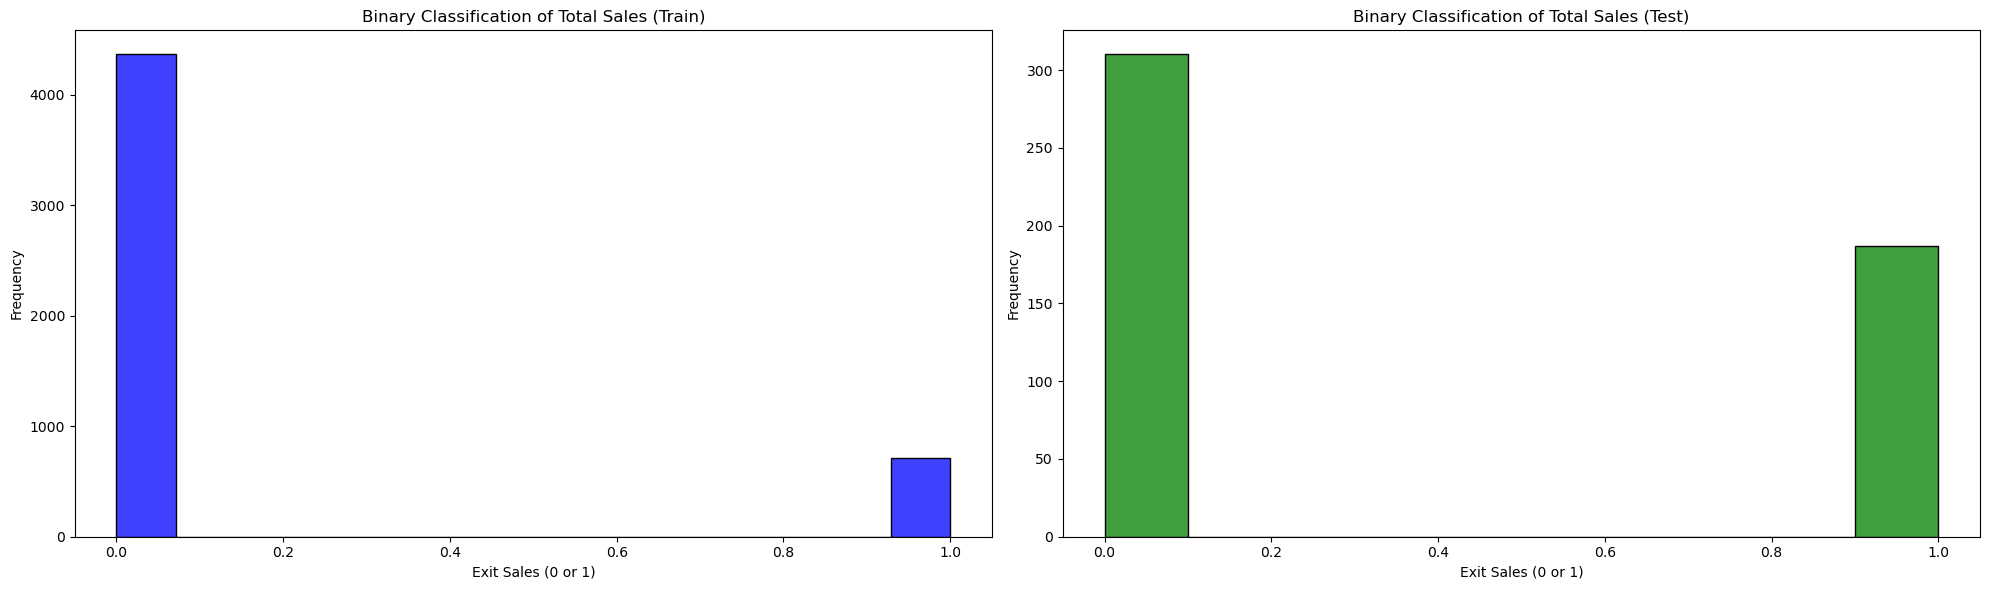

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot binary classification for training data
sns.histplot(exit_sales, kde=False, color='blue', ax=axes[0])
axes[0].set_title("Binary Classification of Total Sales (Train)")
axes[0].set_xlabel("Exit Sales (0 or 1)")
axes[0].set_ylabel("Frequency")

# Plot binary classification for test data
sns.histplot(exit_sales_test, kde=False, color='green', ax=axes[1])
axes[1].set_title("Binary Classification of Total Sales (Test)")
axes[1].set_xlabel("Exit Sales (0 or 1)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [150]:
# Convert Week, Month, and Year to proper integers
sales_trend_df = pd.DataFrame({
    "Week": (temporal_features[:, 1] * 52).astype(int),  # Week of the year
    "Month": (temporal_features[:, 2] * 12).astype(int),  # Month of the year
    "Year": (temporal_features[:, 3] * 10).astype(int),  # Year
    # "Total Sales": total_sales,
    "Total Sales": exit_sales,
    "Category": categories
})

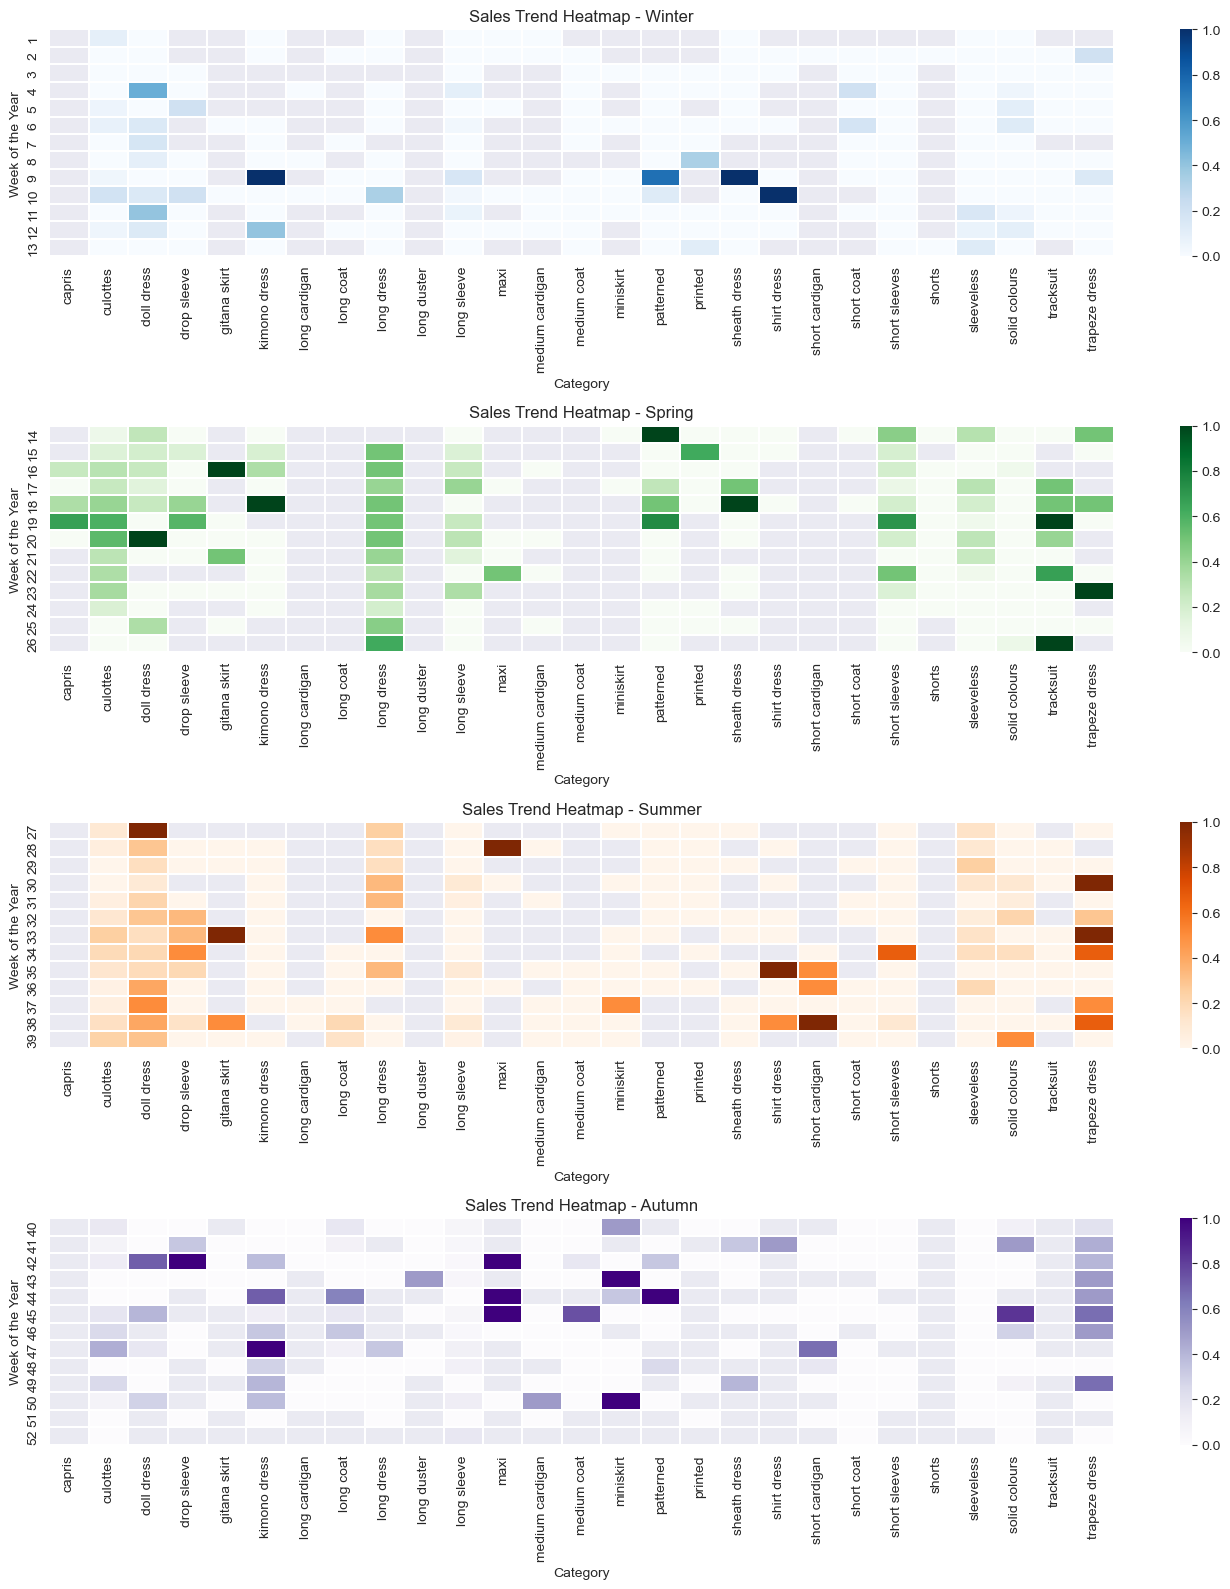

In [151]:
sns.set_style("dark")  # Options: "whitegrid", "darkgrid", "dark", "white", "ticks"

# Define a function to classify weeks into seasons
def classify_season(week):
    if week in range(1, 14):  # Weeks 1-13: Winter
        return "Winter"
    elif week in range(14, 27):  # Weeks 14-26: Spring
        return "Spring"
    elif week in range(27, 40):  # Weeks 27-39: Summer
        return "Summer"
    else:  # Weeks 40-52: Autumn
        return "Autumn"

reversed_cat_dict = {v: k for k, v in cat_dict.items()}

# Apply the classification to create a new Season column
sales_trend_df["Category"] = sales_trend_df["Category"].map(reversed_cat_dict)
all_categories = sorted(sales_trend_df["Category"].unique())

sales_trend_df["Season"] = sales_trend_df["Week"].apply(classify_season)

# Calculate the global min and max for the color scale
global_min = sales_trend_df["Total Sales"].min()
global_max = sales_trend_df["Total Sales"].max()

# Plot the heatmap for each season with different colormaps
plt.figure(figsize=(14, 16))
for i, season in enumerate(["Winter", "Spring", "Summer", "Autumn"]):
    season_data = sales_trend_df[sales_trend_df["Season"] == season]
    season_pivot = season_data.pivot_table(values="Total Sales", index="Week", columns="Category", aggfunc='mean').reindex(columns=all_categories)

    # Plot the heatmap for the current season with a consistent color scale
    plt.subplot(4, 1, i + 1)
    sns.heatmap(season_pivot, cmap="Blues" if season == "Winter" else 
                                      "Greens" if season == "Spring" else 
                                      "Oranges" if season == "Summer" else 
                                      "Purples",
                vmin=global_min, vmax=global_max,
                linewidths=0.1)
    
    plt.title(f"Sales Trend Heatmap - {season}")
    plt.xlabel("Category")
    plt.ylabel("Week of the Year")

plt.tight_layout()
plt.show()

### Extraction of temporal features

In [9]:
# Convert scaled temporal features back to integers
week_of_year = (temporal_features[:, 1] * 52).astype(int)  # Week of the year (1 to 52)
month_of_year = (temporal_features[:, 2] * 12).astype(int)  # Month of the year (1 to 12)
year = (temporal_features[:, 3] * 10).astype(int)  # Year (scaled up to a meaningful range)

# Additional derived features
is_weekend = (week_of_year % 7 >= 5).astype(int)  # Flag indicating if it's a weekend (Saturday or Sunday)
quarter = ((month_of_year - 1) // 3 + 1).astype(int)  # Calculate the quarter (1 to 4)
season = np.select(
    [month_of_year <= 2, (month_of_year >= 3) & (month_of_year <= 5),
     (month_of_year >= 6) & (month_of_year <= 8), month_of_year >= 9],
    [0, 1, 2, 3])  # Define seasons (Winter, Spring, Summer, Fall)

# Combine all features into a new feature matrix
temporal_features_engineered = np.column_stack([
    week_of_year, month_of_year, year, is_weekend, quarter, season
])

In [10]:
# Convert scaled temporal features back to integers for test data
test_week_of_year = (temporal_features_test[:, 1] * 52).astype(int)  # Week of the year (1 to 52)
test_month_of_year = (temporal_features_test[:, 2] * 12).astype(int)  # Month of the year (1 to 12)
test_year = (temporal_features_test[:, 3] * 10).astype(int)  # Year (scaled up to a meaningful range)

# Additional derived features for test data
test_is_weekend = (test_week_of_year % 7 >= 5).astype(int)  # Flag indicating if it's a weekend (Saturday or Sunday)
test_quarter = ((test_month_of_year - 1) // 3 + 1).astype(int)  # Calculate the quarter (1 to 4)
test_season = np.select(
    [test_month_of_year <= 2, (test_month_of_year >= 3) & (test_month_of_year <= 5),
     (test_month_of_year >= 6) & (test_month_of_year <= 8), test_month_of_year >= 9],
    [0, 1, 2, 3])  # Define seasons (Winter, Spring, Summer, Fall)

# Combine all features into a new feature matrix for test data
test_temporal_features_engineered = np.column_stack([
    test_week_of_year, test_month_of_year, test_year, test_is_weekend, test_quarter, test_season
])

### Rolling features

In [11]:
# Get the dimensions of gtrends
num_samples, num_trends, trend_len = gtrends.shape

# Initialize lists for the reduced rolling features
rolling_avg_4w_list = []
rolling_avg_12w_list = []
rolling_sum_4w_list = []
rolling_sum_12w_list = []

# Calculate rolling features for each trend channel
for i in range(num_samples):
    rolling_avg_4w_sample = []
    rolling_avg_12w_sample = []
    rolling_sum_4w_sample = []
    rolling_sum_12w_sample = []
    
    for j in range(num_trends):
        # Use pandas Series to calculate rolling averages and sums for each trend
        gtrend_series = pd.Series(gtrends[i, j])

        # Calculate rolling averages and sums and take the last value of each rolling window
        rolling_avg_4w_sample.append(gtrend_series.rolling(window=4, min_periods=1).mean().iloc[-1])
        rolling_avg_12w_sample.append(gtrend_series.rolling(window=12, min_periods=1).mean().iloc[-1])
        rolling_sum_4w_sample.append(gtrend_series.rolling(window=4, min_periods=1).sum().iloc[-1])
        rolling_sum_12w_sample.append(gtrend_series.rolling(window=12, min_periods=1).sum().iloc[-1])
    
    # Append the results for this sample
    rolling_avg_4w_list.append(rolling_avg_4w_sample)
    rolling_avg_12w_list.append(rolling_avg_12w_sample)
    rolling_sum_4w_list.append(rolling_sum_4w_sample)
    rolling_sum_12w_list.append(rolling_sum_12w_sample)

# Convert lists to arrays
rolling_avg_4w = np.array(rolling_avg_4w_list)
rolling_avg_12w = np.array(rolling_avg_12w_list)
rolling_sum_4w = np.array(rolling_sum_4w_list)
rolling_sum_12w = np.array(rolling_sum_12w_list)

# Combine only the reduced rolling features into a single array
gtrends_with_rolling_reduced = np.hstack([
    rolling_avg_4w, rolling_avg_12w, rolling_sum_4w, rolling_sum_12w
])

In [34]:
gtrends_with_rolling_reduced.shape

(5080, 12)

In [12]:
# Get the dimensions of gtrends_test
num_samples_test, num_trends_test, trend_len_test = gtrends_test.shape

# Initialize lists for the reduced rolling features
rolling_avg_4w_test_list = []
rolling_avg_12w_test_list = []
rolling_sum_4w_test_list = []
rolling_sum_12w_test_list = []

# Calculate rolling features for each trend channel
for i in range(num_samples_test):
    rolling_avg_4w_sample_test = []
    rolling_avg_12w_sample_test = []
    rolling_sum_4w_sample_test = []
    rolling_sum_12w_sample_test = []
    
    for j in range(num_trends_test):
        # Use pandas Series to calculate rolling averages and sums for each trend
        gtrend_test_series = pd.Series(gtrends_test[i, j])

        # Calculate rolling averages and sums and take the last value of each rolling window
        rolling_avg_4w_sample_test.append(gtrend_test_series.rolling(window=4, min_periods=1).mean().iloc[-1])
        rolling_avg_12w_sample_test.append(gtrend_test_series.rolling(window=12, min_periods=1).mean().iloc[-1])
        rolling_sum_4w_sample_test.append(gtrend_test_series.rolling(window=4, min_periods=1).sum().iloc[-1])
        rolling_sum_12w_sample_test.append(gtrend_test_series.rolling(window=12, min_periods=1).sum().iloc[-1])
    
    # Append the results for this sample
    rolling_avg_4w_test_list.append(rolling_avg_4w_sample_test)
    rolling_avg_12w_test_list.append(rolling_avg_12w_sample_test)
    rolling_sum_4w_test_list.append(rolling_sum_4w_sample_test)
    rolling_sum_12w_test_list.append(rolling_sum_12w_sample_test)

# Convert lists to arrays
rolling_avg_4w_test = np.array(rolling_avg_4w_test_list)
rolling_avg_12w_test = np.array(rolling_avg_12w_test_list)
rolling_sum_4w_test = np.array(rolling_sum_4w_test_list)
rolling_sum_12w_test = np.array(rolling_sum_12w_test_list)

# Combine only the reduced rolling features into a single array
gtrends_test_with_rolling_reduced = np.hstack([
    rolling_avg_4w_test, rolling_avg_12w_test,
    rolling_sum_4w_test, rolling_sum_12w_test
])

### Data exploration

##### Temporal Features

### Bag of Words

In [96]:
def denormalize_image(image):
    image = np.transpose(image, (1, 2, 0))   
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = std * image + mean
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    
    return image

step_size = 5
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, 256, step_size) 
                                    for x in range(0, 256, step_size)]

sift = cv2.SIFT_create()
def extact_sift_features_dense(image_array):
    
    image = denormalize_image(image_array)

    _, descriptors = sift.compute(image, kp)
    return descriptors

In [124]:
sift = cv2.SIFT_create()

descriptors_list_dense = []
for image in tqdm(images):
    descriptors = extact_sift_features_dense(image)
    
    if descriptors is not None:
        descriptors_list_dense.append(descriptors)
    else:
        descriptors_list_dense.append(np.zeros((1, 128)))

100%|██████████| 5080/5080 [00:54<00:00, 93.38it/s]


5080

In [127]:
# Stack all descriptors together
all_descriptors = np.vstack(descriptors_list_dense)
print(all_descriptors.shape)
# Use K-means to create a visual vocabulary
k = 200  # Number of visual words
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_descriptors)

# Save the cluster centers as the visual vocabulary
visual_words = kmeans.cluster_centers_

(13736320, 128)


In [130]:
# Save descriptors_list_dense to a file
with open('descriptors_list_dense_2.pkl', 'wb') as file:
    pickle.dump(descriptors_list_dense, file)
np.save('visual_words_2.npy', visual_words)
# Save the KMeans model
with open('kmeans_model_2.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

In [94]:
visual_words = np.load('visual_words_2.npy')
# Load descriptors_list_dense from the file
with open('descriptors_list_dense_2.pkl', 'rb') as file:
    descriptors_list_dense = pickle.load(file)
    # Load the KMeans model
with open('kmeans_model_2.pkl', 'rb') as file:
    kmeans = pickle.load(file)


In [134]:
print(visual_words.shape)

(200, 128)


In [97]:
# Function to create a histogram of visual words for an image
def create_histogram(descriptors, visual_words):
    histogram = np.zeros(len(visual_words))
    if descriptors is not None:
        words = kmeans.predict(descriptors)
        for word in words:
            histogram[word] += 1
    return histogram

# Create histograms for all images
histograms = []
for idx in tqdm(range(len(images))):
    descriptors = descriptors_list_dense[idx]
    histogram = create_histogram(descriptors, visual_words)
    histograms.append(histogram)

# Convert histograms to a NumPy array
X_train_bovw = np.array(histograms)

histograms_test = []
for idx in tqdm(range(len(images_test))):
    descriptors = extact_sift_features_dense(images_test[idx])
    histogram = create_histogram(descriptors, visual_words)
    histograms_test.append(histogram)

X_test_bovw = np.array(histograms_test)

100%|██████████| 497/497 [00:06<00:00, 81.33it/s]


In [40]:
print(f"Shape of BoVW histograms: {X_train_bovw.shape}")
print(f"Shape of item_sales: {item_sales.shape}")
print(f"Shape of categories: {categories.shape}")
print(f"Shape of colors: {colors.shape}")
print(f"Shape of fabrics: {fabrics.shape}")
print(f"Shape of temporal_features: {temporal_features_engineered.shape}")
print(f"Shape of gtrends: {gtrends_with_rolling_reduced.shape}")

print(f"Shape test of BoVW histograms: {X_test_bovw.shape}")
print(f"Shape test of item_sales: {item_sales_test.shape}")
print(f"Shape test of categories: {categories_test.shape}")
print(f"Shape test of colors: {colors_test.shape}")
print(f"Shape test of fabrics: {fabrics_test.shape}")
print(f"Shape test of temporal_features: {test_temporal_features_engineered.shape}")
print(f"Shape test of gtrends: {gtrends_test_with_rolling_reduced.shape}")

Shape of BoVW histograms: (5080, 200)
Shape of item_sales: (5080, 12)
Shape of categories: (5080,)
Shape of colors: (5080,)
Shape of fabrics: (5080,)
Shape of temporal_features: (5080, 6)
Shape of gtrends: (5080, 12)
Shape test of BoVW histograms: (497, 200)
Shape test of item_sales: (497, 12)
Shape test of categories: (497,)
Shape test of colors: (497,)
Shape test of fabrics: (497,)
Shape test of temporal_features: (497, 6)
Shape test of gtrends: (497, 12)


In [139]:
### Filtering by summer indices
summer_indices = np.where(temporal_features_engineered == 2)[0]
# summer_indices = np.ones(len(temporal_features_engineered), dtype=bool)

# X_train_bovw_sum = X_train_bovw[summer_indices]
temporal_features_engineered_sum = temporal_features_engineered[summer_indices]
gtrends_with_rolling_reduced_sum = gtrends_with_rolling_reduced[summer_indices]
categories_sum = categories[summer_indices]
colors_sum = colors[summer_indices]
fabrics_sum = fabrics[summer_indices]
item_sales_sum = item_sales[summer_indices]


summer_indices_test = np.where(test_temporal_features_engineered == 2)[0]
# summer_indices_test = np.ones(len(test_temporal_features_engineered), dtype=bool)

# X_test_bovw_sum = X_test_bovw[summer_indices_test]
test_temporal_features_engineered_sum = test_temporal_features_engineered[summer_indices_test]
gtrends_test_with_rolling_reduced_sum = gtrends_test_with_rolling_reduced[summer_indices_test]
categories_test_sum = categories_test[summer_indices_test]
colors_test_sum = colors_test[summer_indices_test]
fabrics_test_sum = fabrics_test[summer_indices_test]
item_sales_test_sum = item_sales_test[summer_indices_test]

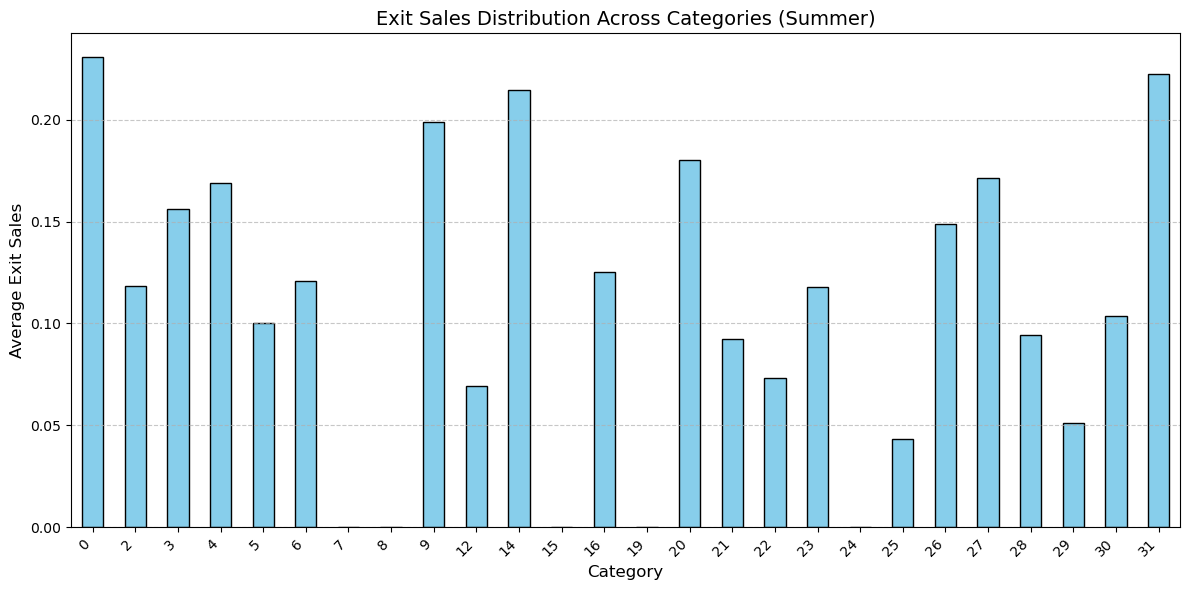

In [140]:
# For simplicity, we'll plot the first trend channel for the first few samples

exit_sales_sum = (item_sales_sum[:, 0] >= 0.03).astype(int)

# Create a DataFrame to organize data
data = pd.DataFrame({
    'Category': categories_sum,
    'Exit Sales': exit_sales_sum
})

# Group by category and calculate the average exit sales for each category
category_exit_sales = data.groupby('Category')['Exit Sales'].mean()

# Plotting
plt.figure(figsize=(12, 6))
category_exit_sales.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Exit Sales Distribution Across Categories (Summer)', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Exit Sales', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [163]:
X_summer = np.column_stack([
    X_train_bovw[summer_indices],
    temporal_features_engineered_sum[:, 1],
    categories_sum,
    colors_sum,
    rolling_avg_4w[summer_indices],
    rolling_sum_4w[summer_indices]
])

# Target variable
# y_summer = item_sales_sum[:, 0]
# y_summer = exit_sales[summer_indices]
# y_summer = (item_sales_sum[:, 0] >= 0.03).astype(int)
median_sales_sum = np.median(
    np.concatenate([item_sales_sum, item_sales_test_sum], axis=0).sum(axis=1)
)

high_low_sales_sum = (total_sales >= median_sales_sum).astype(int)
y_summer = high_low_sales_sum

X_summer_test = np.column_stack([
    X_test_bovw[summer_indices_test],
    test_temporal_features_engineered_sum[:, 1],
    categories_test_sum,
    colors_test_sum,
    rolling_avg_4w_test[summer_indices_test],
    rolling_sum_4w_test[summer_indices_test]
])
# y_summer_test = item_sales_test_sum[:, 0]
# y_summer_test = exit_sales_test[summer_indices_test]
# y_summer_test = (item_sales_test_sum[:, 0] >= 0.03).astype(int)
high_low_sales_sum_test = (total_sales_test >= median_sales_sum).astype(int)
y_summer_test = high_low_sales_sum_test


In [164]:
# Count the number of instances in each class for training set
unique, counts = np.unique(y_summer, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution in training set:", class_distribution)

# Count the number of instances in each class for test set
unique_test, counts_test = np.unique(y_summer_test, return_counts=True)
class_distribution_test = dict(zip(unique_test, counts_test))
print("Class distribution in test set:", class_distribution_test)


Class distribution in training set: {0: 2484, 1: 2596}
Class distribution in test set: {0: 172, 1: 325}


### UMAP

In [143]:
# Initialize UMAP
umap_model = umap.UMAP(
    n_neighbors=15,    # Balances local and global structure
    min_dist=0.1,      # Controls the tightness of the embedding
    metric='euclidean',# Distance metric
    random_state=42    # For reproducibility
)

# Fit UMAP on the training data and transform
embedding_train = umap_model.fit_transform(X_summer)

# Transform the test data using the same UMAP model
embedding_test = umap_model.transform(X_summer_test)


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


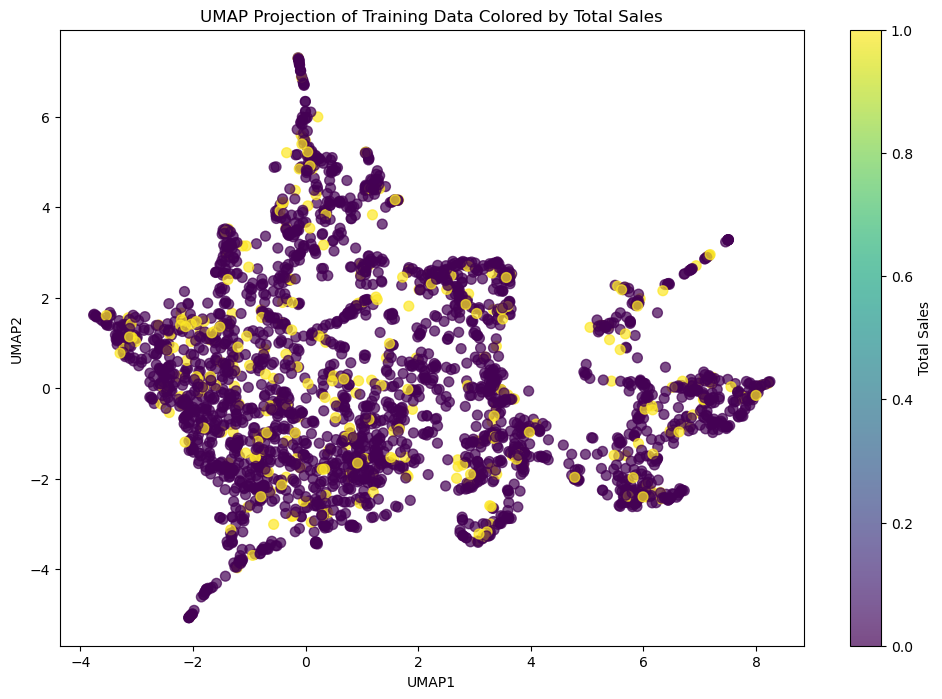

In [144]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embedding_train[:, 0],
    embedding_train[:, 1],
    c=y_summer,
    cmap='viridis',
    s=50,
    alpha=0.7
)
plt.colorbar(scatter, label='Total Sales')
plt.title('UMAP Projection of Training Data Colored by Total Sales')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=33)

X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_summer, y_summer)

# X_summer_under, y_summer_under = RandomUnderSampler(random_state=42).fit_resample(X_summer, y_summer)

# model = XGBClassifier(n_estimators=200, random_state=42)#, class_weight='balanced')
model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / 
                     len(y_train_resampled[y_train_resampled == 1]),
    random_state=42
)

model.fit(X_train_resampled, y_train_resampled)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_summer_test)
print(classification_report(y_summer_test, y_pred))
print(confusion_matrix(y_summer_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       203
           1       0.32      0.40      0.36        47

    accuracy                           0.72       250
   macro avg       0.58      0.60      0.59       250
weighted avg       0.75      0.72      0.74       250

[[162  41]
 [ 28  19]]


In [146]:
from sklearn.metrics import roc_auc_score, roc_curve

y_prob = model.predict_proba(X_summer_test)[:, 1]

# Find the best threshold based on the ROC curve
fpr, tpr, thresholds = roc_curve(y_summer_test, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply the new threshold
y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)

# Evaluate
print(classification_report(y_summer_test, y_pred_adjusted))
print(confusion_matrix(y_summer_test, y_pred_adjusted))
print(roc_auc_score(y_summer_test, y_prob))
print("With optimal threshold:", optimal_threshold)

              precision    recall  f1-score   support

           0       0.87      0.77      0.82       203
           1       0.34      0.51      0.41        47

    accuracy                           0.72       250
   macro avg       0.60      0.64      0.61       250
weighted avg       0.77      0.72      0.74       250

[[156  47]
 [ 23  24]]
0.6202704119065088
With optimal threshold: 0.4571054


Top 10 Most Important Features:
1. feature_182: 0.0349
2. feature_103: 0.0316
3. feature_200: 0.0275
4. feature_113: 0.0233
5. feature_153: 0.0182
6. feature_201: 0.0174
7. feature_100: 0.0173
8. feature_181: 0.0171
9. feature_155: 0.0146
10. feature_169: 0.0127


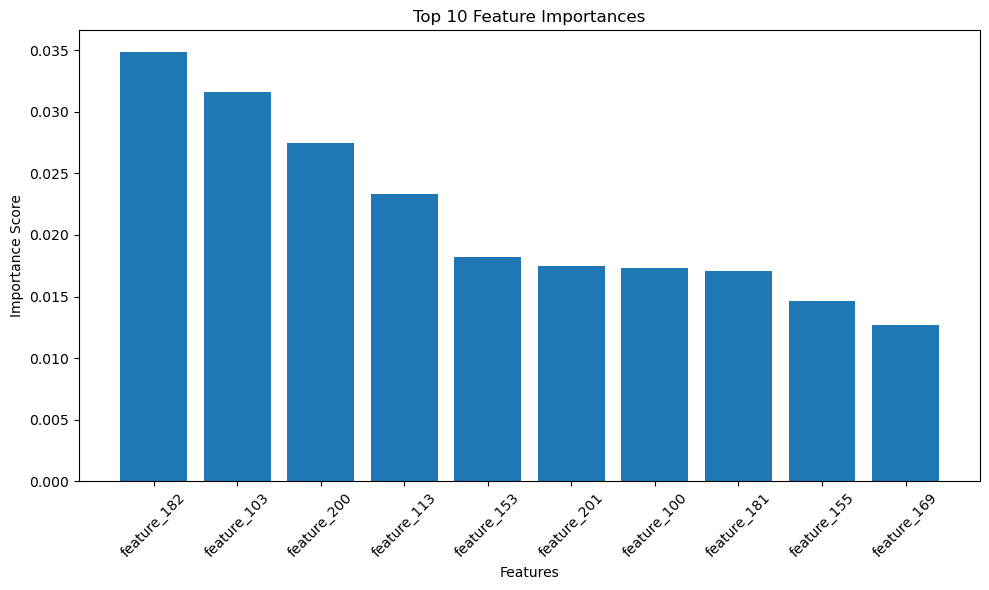

In [147]:
feature_names = ['feature_{}'.format(i) for i in range(X_summer.shape[1])]

importance = model.feature_importances_
sorted_idx = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

# Define the number of top features you want to display
top_n = 10
top_features = sorted_features[:top_n]
top_importance = sorted_importance[:top_n]

# Display the top N features with their importance scores
print(f"Top {top_n} Most Important Features:")
for i in range(top_n):
    print(f"{i+1}. {top_features[i]}: {top_importance[i]:.4f}")

# Optional: Plot the top N features
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), top_importance, align="center")
plt.xticks(range(top_n), top_features, rotation=45)
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

#### Specific Category

In [152]:
reversed_cat_dict

{0: 'capris',
 1: 'cloak',
 2: 'culottes',
 3: 'doll dress',
 4: 'drop sleeve',
 5: 'gitana skirt',
 6: 'kimono dress',
 7: 'long cardigan',
 8: 'long coat',
 9: 'long dress',
 10: 'long duster',
 11: 'long skirt',
 12: 'long sleeve',
 13: 'longuette skirt',
 14: 'maxi',
 15: 'medium cardigan',
 16: 'medium coat',
 17: 'medium duster',
 18: 'midi skirt',
 19: 'miniskirt',
 20: 'patterned',
 21: 'printed',
 22: 'sheath dress',
 23: 'shirt dress',
 24: 'short cardigan',
 25: 'short coat',
 26: 'short sleeves',
 27: 'shorts',
 28: 'sleeveless',
 29: 'solid colours',
 30: 'tracksuit',
 31: 'trapeze dress'}

In [153]:
specific_category_indices = np.where(categories == 9)[0] 

In [155]:
median_sales_sum = np.median(item_sales_sum.sum(axis=1))
high_low_sales = (total_sales >= median_sales).astype(int)

array([0, 1, 1, ..., 1, 0, 1])

### Models

### Models OLD

In [117]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the AdaBoost classifier
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

# Train the model
model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [107]:
# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred))

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Print confusion matrix
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_train_pred))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

Training Accuracy: 1.0000
Test Accuracy: 0.8109
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4752
           1       1.00      1.00      1.00       328

    accuracy                           1.00      5080
   macro avg       1.00      1.00      1.00      5080
weighted avg       1.00      1.00      1.00      5080

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       403
           1       0.00      0.00      0.00        94

    accuracy                           0.81       497
   macro avg       0.41      0.50      0.45       497
weighted avg       0.66      0.81      0.73       497

Confusion Matrix (Train):
[[4752    0]
 [   0  328]]
Confusion Matrix (Test):
[[403   0]
 [ 94   0]]


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

### SMOTE Oversampling

In [118]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [119]:
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [120]:
# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred))

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Print confusion matrix
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_train_pred))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

Training Accuracy: 1.0000
Test Accuracy: 0.6258
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4365
           1       1.00      1.00      1.00       715

    accuracy                           1.00      5080
   macro avg       1.00      1.00      1.00      5080
weighted avg       1.00      1.00      1.00      5080

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       310
           1       1.00      0.01      0.01       187

    accuracy                           0.63       497
   macro avg       0.81      0.50      0.39       497
weighted avg       0.77      0.63      0.48       497

Confusion Matrix (Train):
[[4365    0]
 [   0  715]]
Confusion Matrix (Test):
[[310   0]
 [186   1]]


In [121]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression


# Apply downsampling
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_scaled, y_train)

# model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=None)
# model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
# model.fit(X_train_scaled, y_train)

# model = LogisticRegression(random_state=42, max_iter=1000)
model = LogisticRegression(
    penalty='elasticnet', 
    solver='saga',        # Required for Elastic Net
    l1_ratio=0.5,         # Balance between L1 and L2 regularization
    C=1.0,
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
# model.fit(X_train_resampled, y_train_resampled)
model.fit(X_train_scaled, y_train)

# Evaluate on original test set
y_test_pred = model.predict(X_test_scaled)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix (Train):")
print(confusion_matrix(y_train, y_train_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

Training Accuracy: 0.6529527559055118
Test Accuracy: 0.607645875251509

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.93      0.65      0.76      4365
           1       0.24      0.69      0.36       715

    accuracy                           0.65      5080
   macro avg       0.58      0.67      0.56      5080
weighted avg       0.83      0.65      0.71      5080


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.76      0.55      0.63       310
           1       0.49      0.71      0.58       187

    accuracy                           0.61       497
   macro avg       0.62      0.63      0.61       497
weighted avg       0.66      0.61      0.61       497


Confusion Matrix (Train):
[[2827 1538]
 [ 225  490]]

Confusion Matrix (Test):
[[169 141]
 [ 54 133]]


In [33]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(1022, 221)
(1022,)


In [35]:
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),                   # Scale features
    ('undersampler', RandomUnderSampler(random_state=42)),  # Downsample majority class
    ('classifier', LogisticRegression(penalty='l2', random_state=42, max_iter=1000))
])

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the original test set
y_test_pred = pipeline.predict(X_test)

In [36]:
# Evaluate the model
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       446
           1       0.11      0.24      0.15        51

    accuracy                           0.73       497
   macro avg       0.51      0.51      0.50       497
weighted avg       0.82      0.73      0.77       497

Confusion Matrix (Test):
[[353  93]
 [ 39  12]]


In [37]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Initialize the scaler
scaler = StandardScaler()

# Initialize the Balanced Random Forest classifier
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight=None
)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('classifier', brf)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = pipeline.predict(X_test)

# Evaluate the model
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` 

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       446
           1       0.13      0.47      0.20        51

    accuracy                           0.62       497
   macro avg       0.52      0.55      0.48       497
weighted avg       0.83      0.62      0.70       497

Confusion Matrix (Test):
[[285 161]
 [ 27  24]]


In [26]:
from imblearn.combine import SMOTEENN

# Initialize the scaler
scaler = StandardScaler()

# Ini[[285 161]
#  [ 27  24]]tialize SMOTEENN
# https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106
# https://www.fharrell.com/post/classification/
smoteenn = SMOTEENN(random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight=None,
    random_state=42,
    max_iter=1000
)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('smoteenn', smoteenn),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = pipeline.predict(X_test)

# Evaluate the model
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

NameError: name 'LogisticRegression' is not defined

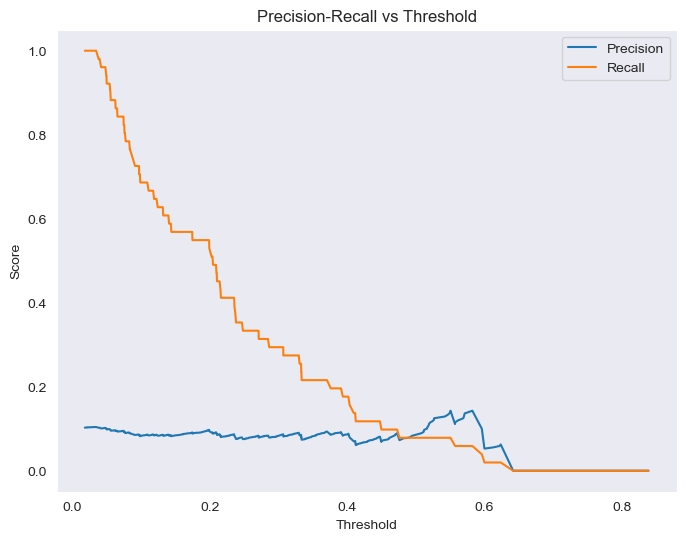

Optimal Threshold: 0.03
Classification Report (Test) with Optimal Threshold:
              precision    recall  f1-score   support

           0       1.00      0.02      0.03       446
           1       0.10      1.00      0.19        51

    accuracy                           0.12       497
   macro avg       0.55      0.51      0.11       497
weighted avg       0.91      0.12      0.05       497

Confusion Matrix (Test) with Optimal Threshold:
[[  7 439]
 [  0  51]]


In [112]:

# Initialize the scaler
scaler = StandardScaler()

# Initialize the Logistic Regression model
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict probabilities
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()

# Find the optimal threshold (e.g., where F1-score is maximized)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Apply the optimal threshold
y_test_pred_optimal = (y_probs >= optimal_threshold).astype(int)

# Evaluate the model with the optimal threshold
print("Classification Report (Test) with Optimal Threshold:")
print(classification_report(y_test, y_test_pred_optimal))

print("Confusion Matrix (Test) with Optimal Threshold:")
print(confusion_matrix(y_test, y_test_pred_optimal))


In [116]:
# Initialize the scaler
scaler = StandardScaler()

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Initialize the Logistic Regression model with class_weight
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',  # Combining with SMOTE
    random_state=42,
    max_iter=1000
)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('smote', smote),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = pipeline.predict(X_test)

# Evaluate the model
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       446
           1       0.07      0.06      0.06        51

    accuracy                           0.82       497
   macro avg       0.48      0.49      0.48       497
weighted avg       0.81      0.82      0.82       497

Confusion Matrix (Test):
[[407  39]
 [ 48   3]]


In [118]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Initialize the scaler
scaler = StandardScaler()

# Initialize the XGBoost classifier with scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('classifier', xgb_clf)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = pipeline.predict(X_test)

# Evaluate the model
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:52:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       446
           1       1.00      0.02      0.04        51

    accuracy                           0.90       497
   macro avg       0.95      0.51      0.49       497
weighted avg       0.91      0.90      0.85       497

Confusion Matrix (Test):
[[446   0]
 [ 50   1]]


In [ ]:
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)